In [74]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # For reading image files

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Dropout

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import misc, ndimage  # For image processing

# Import for plotting model architecture
from tensorflow.keras.utils import plot_model  # For creating a visual representation of the model

from tabulate import tabulate

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [75]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [76]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

In [77]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [78]:
# Iterate through each category within the categories list 
for category in categories:
    # Construct the path to the training images directory for the current category
    tr = os.path.join(train_path, category)
    # Get the number of training images in the current category
    len_tr = len(os.listdir(tr))

    # Construct the path to the validation images directory for the current category
    val = os.path.join(valid_path, category)
    # Get the number of validation images in the current category
    len_val = len(os.listdir(val))

    # Construct the path to the test images directory for the current category
    test = os.path.join(test_path, category)
    # Get the number of test images in the current category
    len_test = len(os.listdir(test))

    # Printing the category names and the training, validation and test images for each category
    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

In [79]:
# Create a data generator for the training dataset
# This generator will load and preprocess images from the 'train_path' directory
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=32
)
# Create a data generator for the validation dataset
# This generator will load and preprocess images from the 'valid_path' directory
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16
)
# Create a data generator for the test dataset
# This generator will load and preprocess images from the 'test_path' directory
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16,
    shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


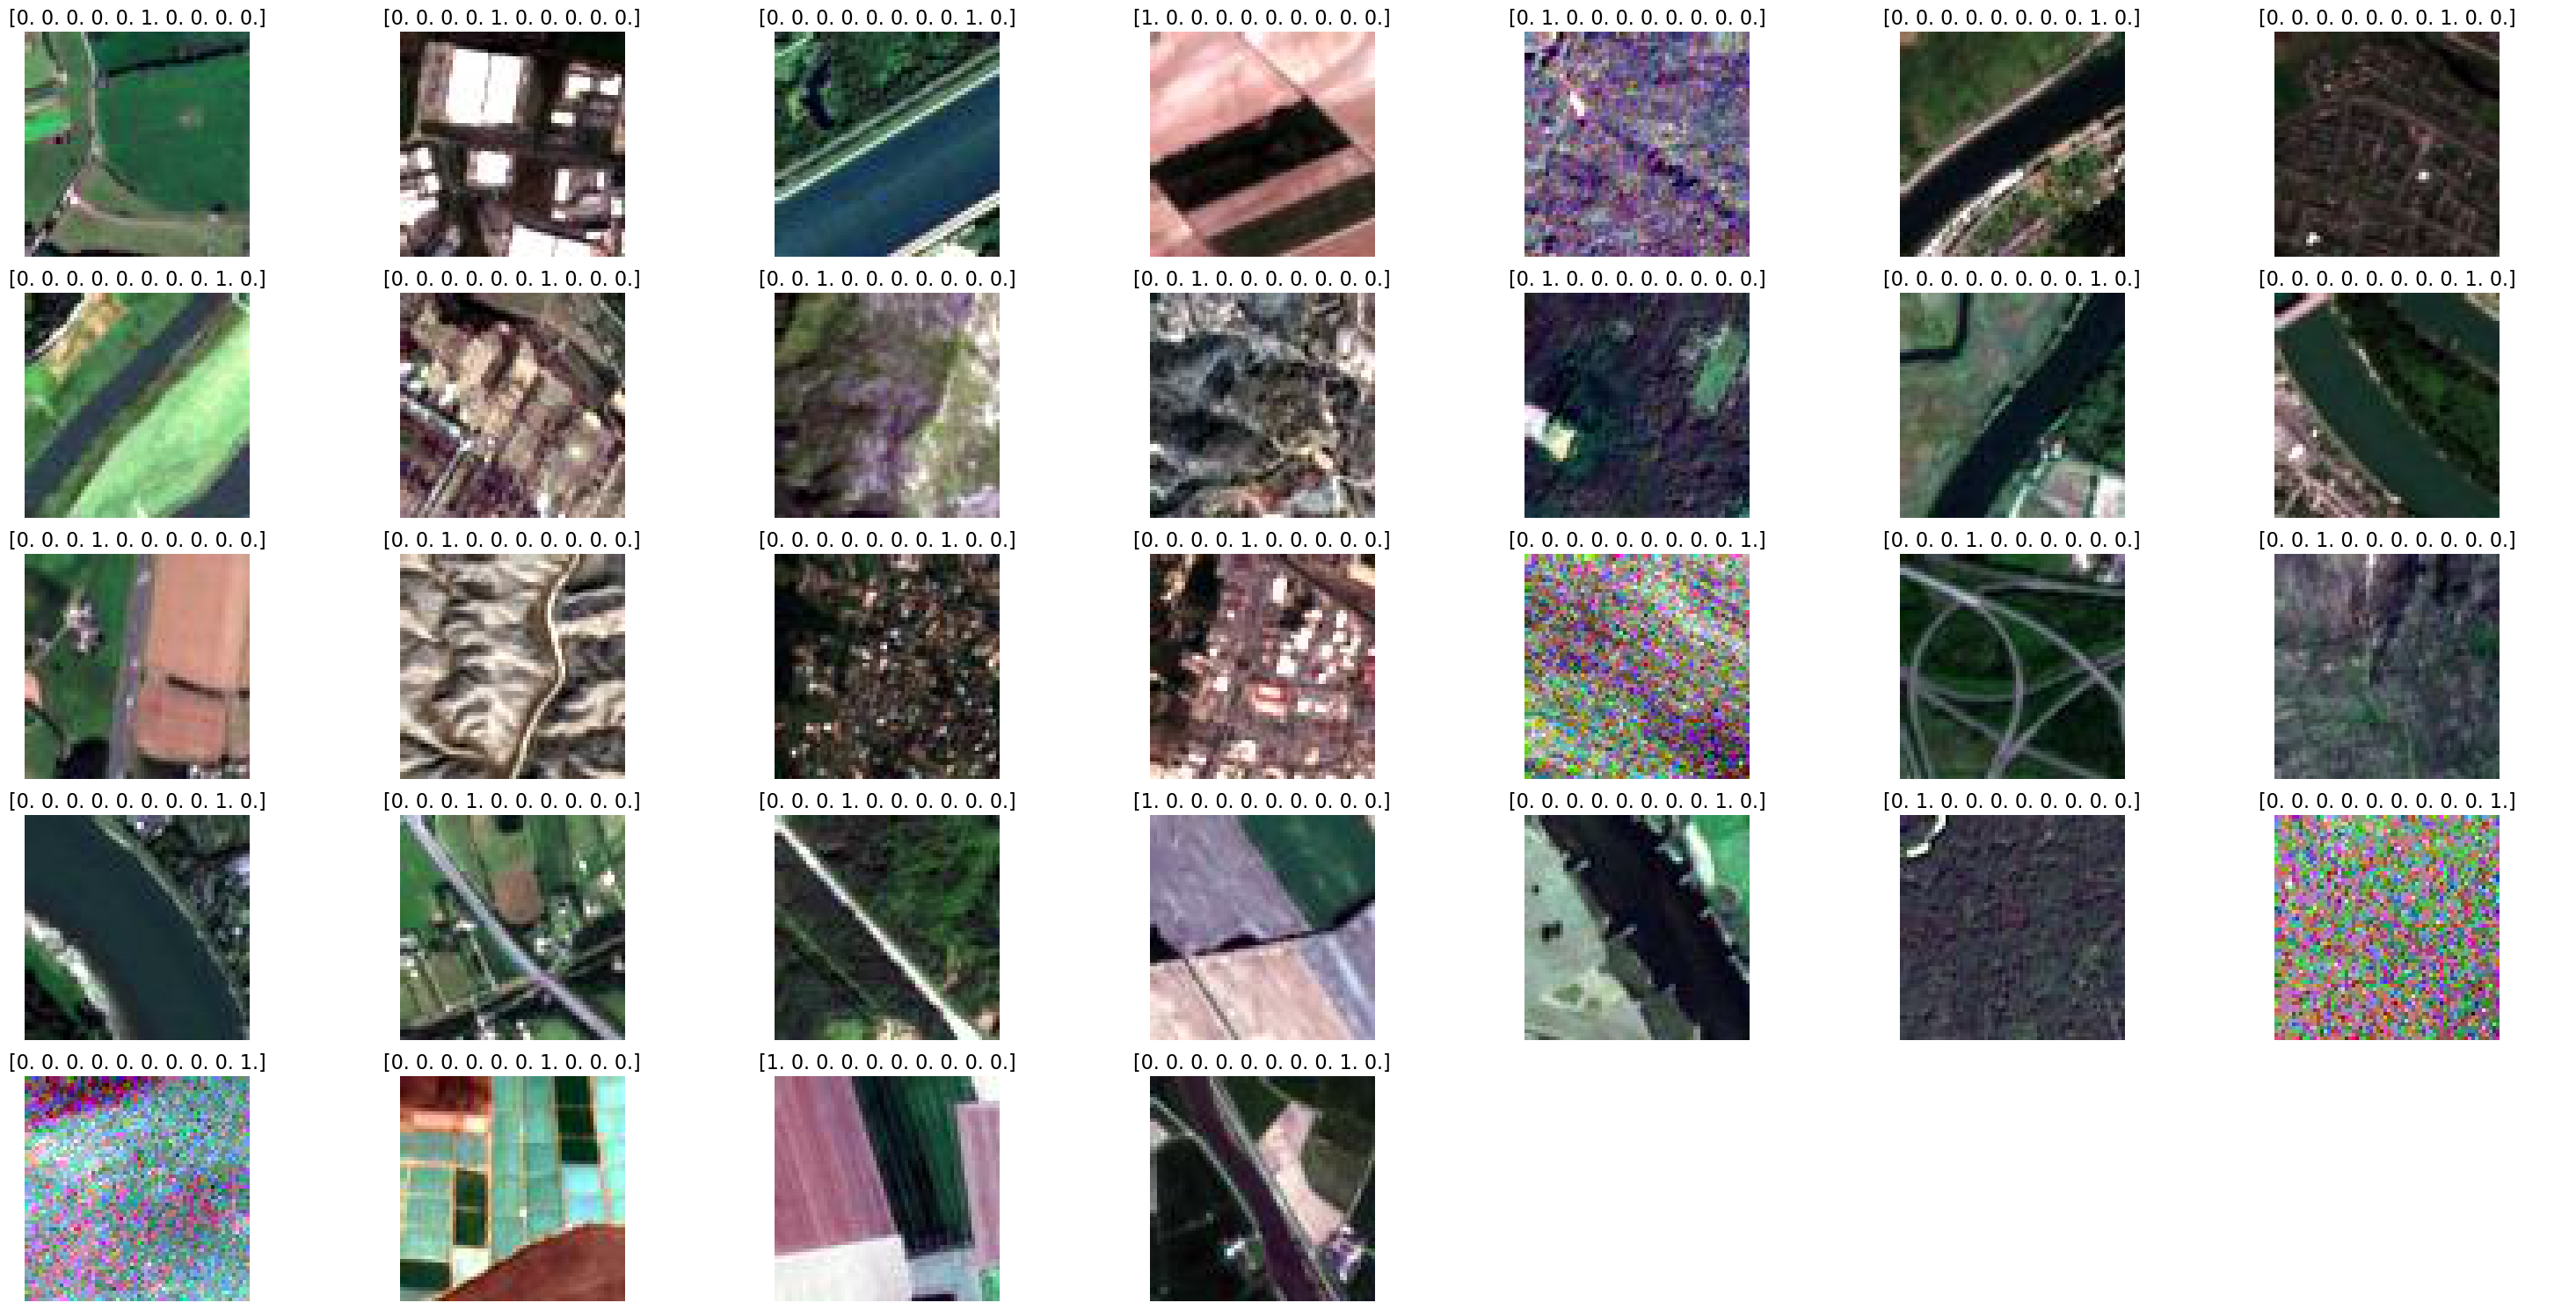

In [80]:
# Function to plot images with labels within a Jupyter notebook
# Adapted from GitHub/YouTube user deeplizard
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    # Check if the input is a list of numpy arrays
    if isinstance(ims[0], np.ndarray):
        # Convert to uint8 type for image display
        ims = np.array(ims).astype(np.uint8)
        # Ensure the images have the correct shape for display
        if ims.shape[-1] != 3:  # Check if the last dimension is not 3 (RGB channels)
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    # Create a new figure with the specified size
    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    
    # Flatten axes array if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Iterate through images and plot them
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')  # Turn off axis lines and labels
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)  # Set title if provided
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear')  # Display image
        else:
            ax.axis('Off')  # Hide any extra subplots
    
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
    plt.show()  # Display the figure

# Example usage with a batch of images and labels
imgs, labels = next(train_batches)  # Get a batch of images and labels from the data generator
plots(imgs, rows=5, titles=labels)  # Plot the images with titles

In [81]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)), # convolutions
        Flatten(), # flatten into 1-D tensor
        Dense(10, activation='softmax') #output layer that categorizes images
])

In [82]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
%%time
# fits the model on data generated batch by batch by ImageDataGenerator
history = model.fit(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=5,
                   verbose=2)

Epoch 1/5
1080/1080 - 9s - 9ms/step - accuracy: 0.3407 - loss: 39.6146 - val_accuracy: 0.4356 - val_loss: 13.6906
Epoch 2/5
1080/1080 - 10s - 9ms/step - accuracy: 0.5877 - loss: 7.3042 - val_accuracy: 0.5089 - val_loss: 7.2699
Epoch 3/5
1080/1080 - 9s - 9ms/step - accuracy: 0.7729 - loss: 1.9972 - val_accuracy: 0.5296 - val_loss: 6.5138
Epoch 4/5
1080/1080 - 9s - 8ms/step - accuracy: 0.8796 - loss: 0.7102 - val_accuracy: 0.5311 - val_loss: 5.6731
Epoch 5/5
1080/1080 - 9s - 8ms/step - accuracy: 0.9419 - loss: 0.2947 - val_accuracy: 0.5437 - val_loss: 5.9380
CPU times: total: 12.3 s
Wall time: 46.1 s


In [84]:
# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes
# Print the class indices of the test images
print(test_labels)

print()

# Get the class-to-index mapping from the test_batches ImageDataGenerator
test_batches.class_indices

[0 0 0 ... 9 9 9]



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [96]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

# Step 2: Extract Predicted Labels
predicted_labels = np.argmax(predictions, axis=1)

Confusion matrix, without normalization
[[101   6   8   3   5  10   7   3   4   3]
 [  2 108  10   1   0   9   1   7   4   8]
 [ 16   6  70   4   3   2  18  23   5   3]
 [ 11   5   6  47   2   5  16  19  11   3]
 [  2   0   5   3  57   0   9  46   3   0]
 [  8  12   9   4   0  39   4   0  18   6]
 [ 15   1  27   6   6   4  38  25   3   0]
 [  0   3   3   2   6   2   7 127   0   0]
 [ 18   5  11  16   2  11  10  10  40   2]
 [  9  14   0   3   1   8   2   1   3 109]]


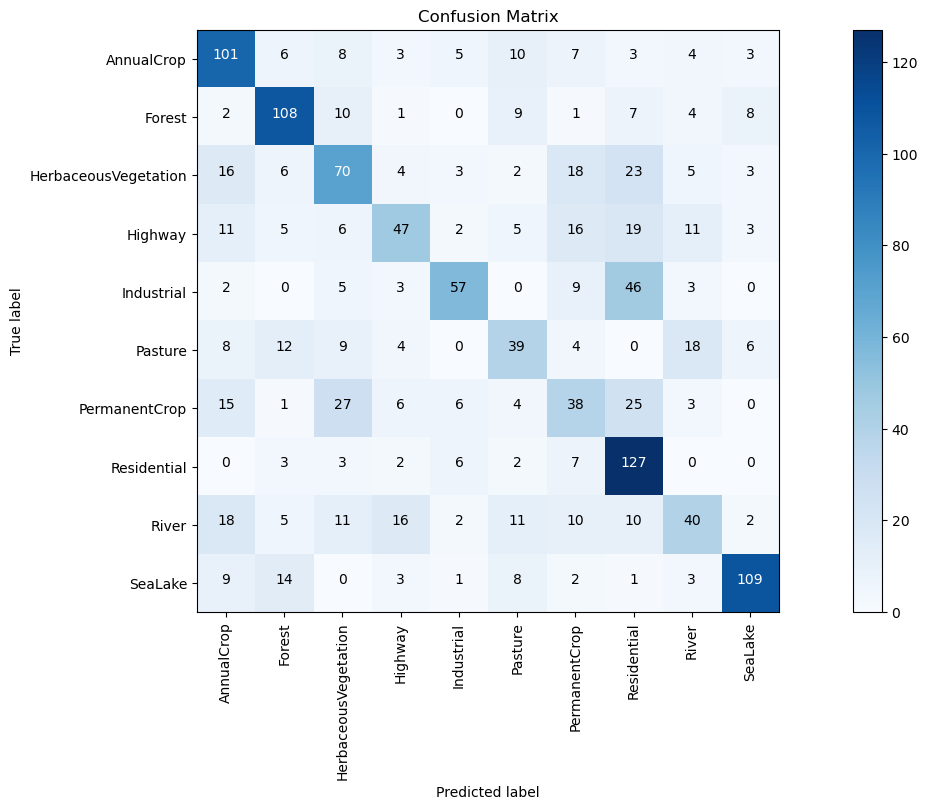

In [97]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):                
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 8))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a colorbar to the plot
    
    # Set the tick marks and labels for the x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Rotate x-axis labels 90 degrees
    plt.yticks(tick_marks, classes)
            
    print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Set a threshold to determine text color based on the matrix value
    thresh = cm.max() / 2.
    
    # Iterate over the confusion matrix to add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # Adjust the layout to fit the plot and add labels for the axes
    plt.tight_layout()
    plt.ylabel("True label")  # Label for the y-axis
    plt.xlabel("Predicted label")  # Label for the x-axis


# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

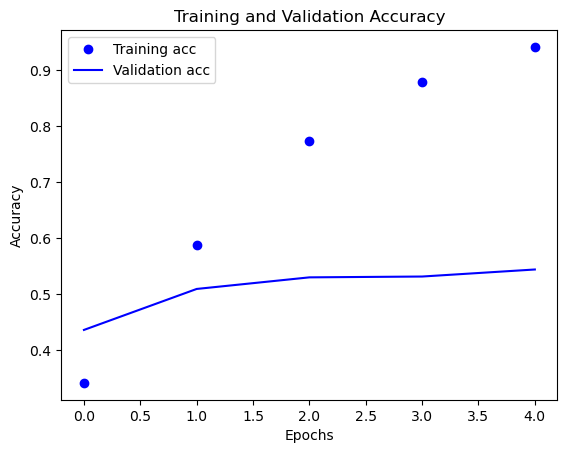

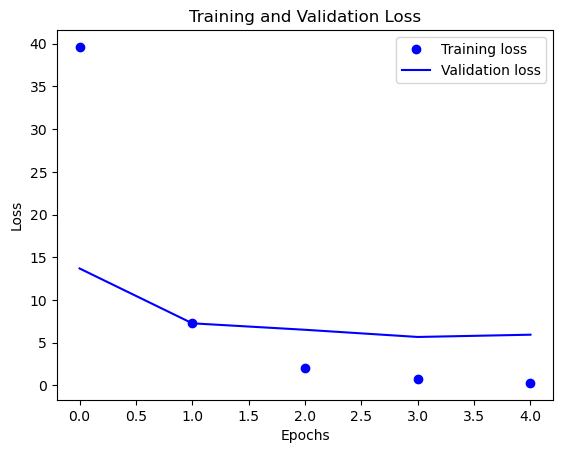

In [86]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Plot training and validation accuracy over epochs
plt.plot(epochs, acc, 'bo', label='Training acc')  # Plot training accuracy with blue dots
plt.plot(epochs, val_acc, 'b', label='Validation acc')  # Plot validation accuracy with a solid blue line
plt.title('Training and Validation Accuracy')  # Title of the accuracy plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation accuracy

# Create a new figure for the loss plot
plt.figure()

# Plot training and validation loss over epochs
plt.plot(epochs, loss, 'bo', label='Training loss')  # Plot training loss with blue dots
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot validation loss with a solid blue line
plt.title('Training and Validation Loss')  # Title of the loss plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation loss

# Display the plots
plt.show()  # Show the training and validation accuracy and loss plots

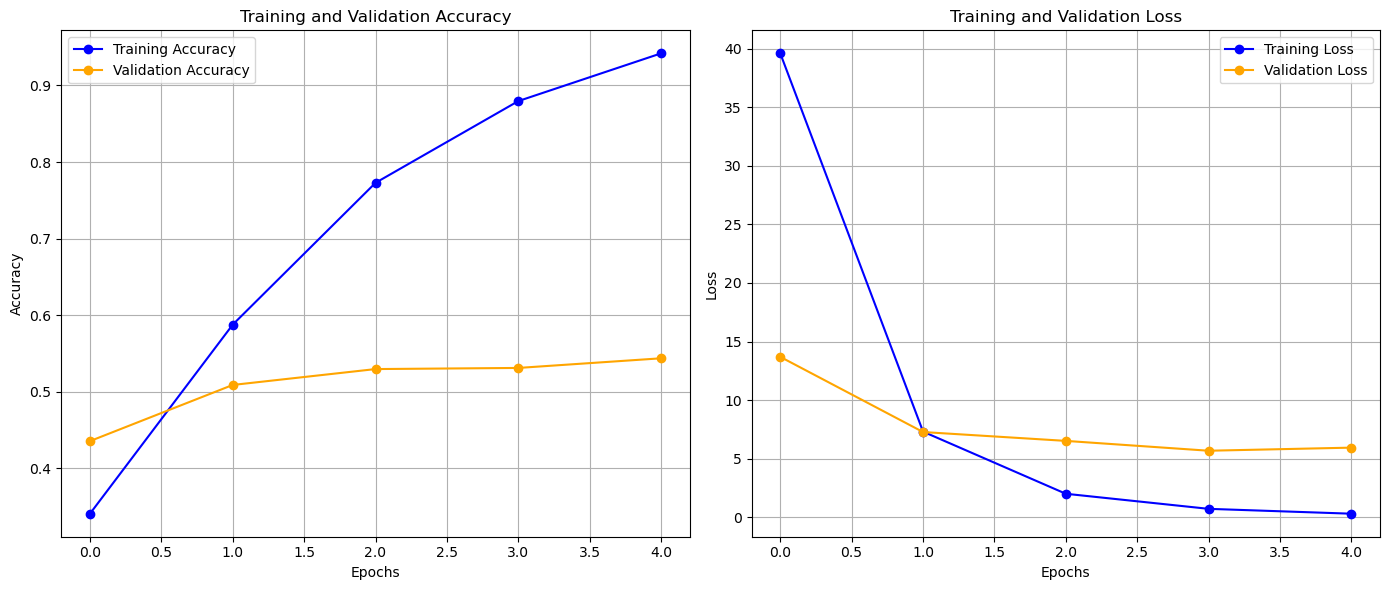

In [87]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Create a new figure with subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy over epochs
ax1.plot(epochs, acc, 'o-', color='blue', label='Training Accuracy')  # Plot training accuracy with blue line and markers
ax1.plot(epochs, val_acc, 'o-', color='orange', label='Validation Accuracy')  # Plot validation accuracy with orange line and markers
ax1.set_title('Training and Validation Accuracy')  # Title of the accuracy plot
ax1.set_xlabel('Epochs')  # X-axis label
ax1.set_ylabel('Accuracy')  # Y-axis label
ax1.legend()  # Display the legend to differentiate between training and validation accuracy
ax1.grid(True)  # Add grid lines for better readability

# Plot training and validation loss over epochs
ax2.plot(epochs, loss, 'o-', color='blue', label='Training Loss')  # Plot training loss with blue line and markers
ax2.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss')  # Plot validation loss with orange line and markers
ax2.set_title('Training and Validation Loss')  # Title of the loss plot
ax2.set_xlabel('Epochs')  # X-axis label
ax2.set_ylabel('Loss')  # Y-axis label
ax2.legend()  # Display the legend to differentiate between training and validation loss
ax2.grid(True)  # Add grid lines for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()  # Show the training and validation accuracy and loss plots

In [88]:
# Generate a classification report
report = classification_report(test_labels, predictions.argmax(axis=1), target_names=categories)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.55      0.67      0.61       150
              Forest       0.68      0.72      0.70       150
HerbaceousVegetation       0.47      0.47      0.47       150
             Highway       0.53      0.38      0.44       125
          Industrial       0.70      0.46      0.55       125
             Pasture       0.43      0.39      0.41       100
       PermanentCrop       0.34      0.30      0.32       125
         Residential       0.49      0.85      0.62       150
               River       0.44      0.32      0.37       125
             SeaLake       0.81      0.73      0.77       150

            accuracy                           0.55      1350
           macro avg       0.54      0.53      0.53      1350
        weighted avg       0.55      0.55      0.54      1350



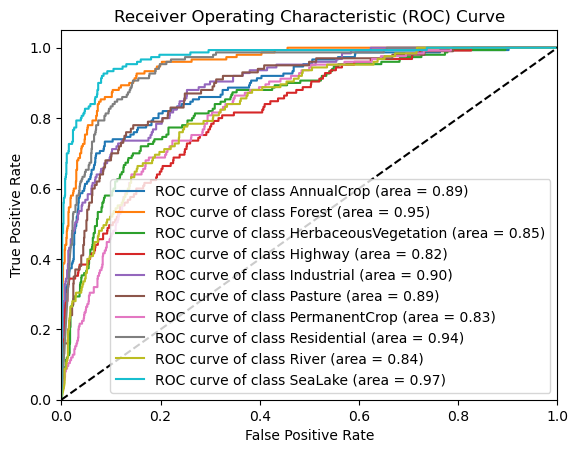

In [89]:
# Binarize the test labels for multi-class ROC curve
y_test_binarized = label_binarize(test_labels, classes=np.arange(len(categories)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

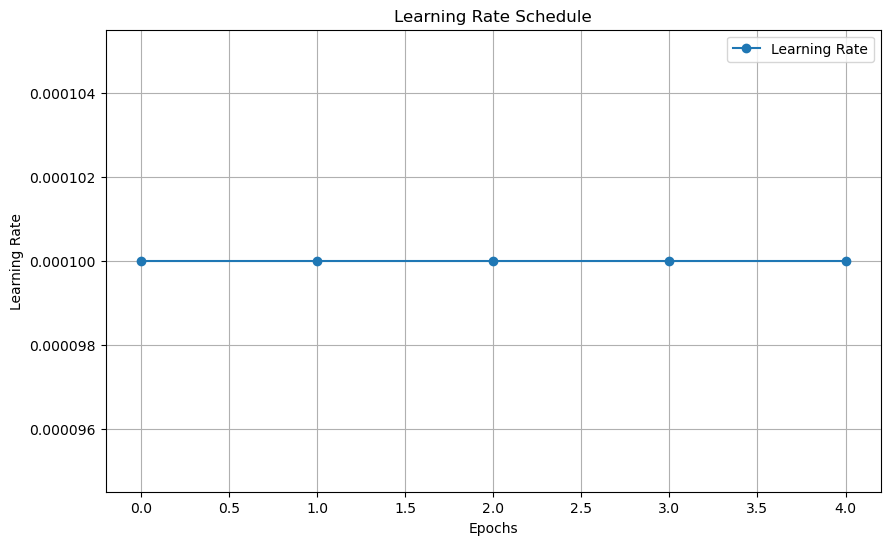

In [90]:
# Assuming you used a learning rate scheduler
lr_schedule = history.history['lr'] if 'lr' in history.history else [0.0001] * len(epochs)

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr_schedule, 'o-', label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


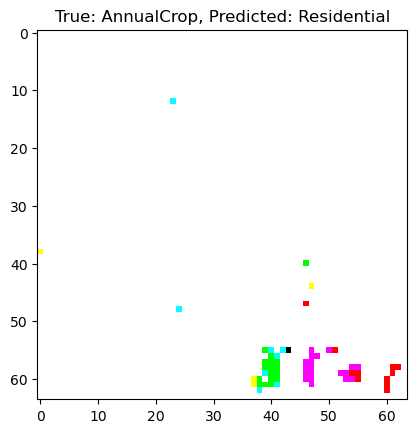

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


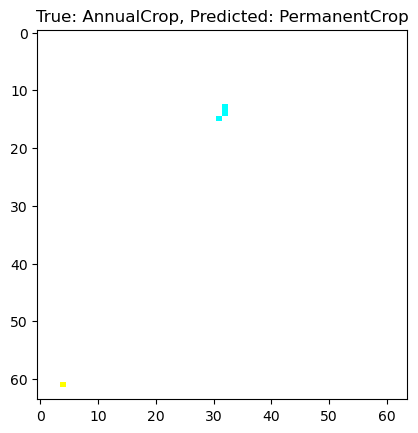

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


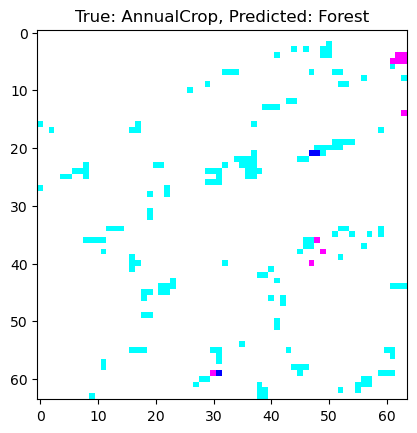

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


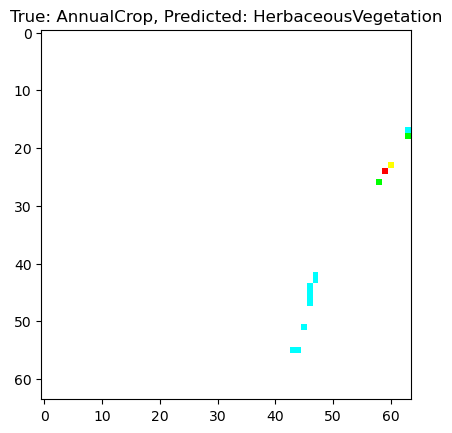

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


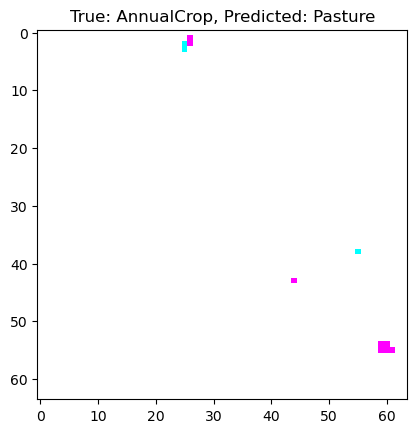

In [91]:
# Step 1: Compute Predictions
predictions = model.predict(test_batches, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Extract True Labels and Images
true_labels = []
images = []
test_batches.reset()  # Reset the generator to start from the beginning

for _ in range(len(test_batches)):  # Iterate through the generator
    x_batch, y_batch = next(test_batches)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoding to class indices
    images.extend(x_batch)

true_labels = np.array(true_labels)
images = np.array(images)

# Ensure the lengths match
assert len(true_labels) == len(predicted_labels), "Mismatch in number of true labels and predictions"

# Step 3: Identify Misclassified Samples
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Step 4: Visualize Misclassified Samples
for i in range(5):  # Display 5 misclassified samples
    index = misclassified_indices[i]
    plt.imshow(images[index])  # Assuming images contains the raw image data
    plt.title(f"True: {categories[true_labels[index]]}, Predicted: {categories[predicted_labels[index]]}")
    plt.show()


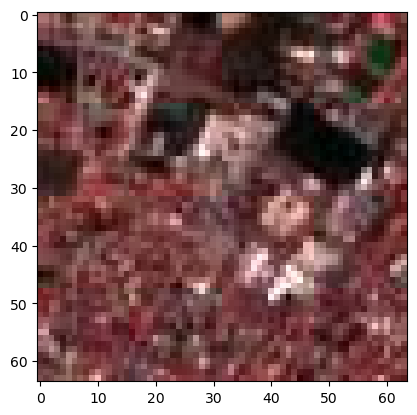

Image tensor shape: (1, 64, 64, 3)


In [92]:
# Load and preprocess the image
img_path = test_path + '/Residential/Residential_26.jpg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Visualize the image
plt.imshow(img_tensor[0])
plt.show()

# Ensure the shape matches the model's input requirements
print("Image tensor shape:", img_tensor.shape) 

In [93]:
# Assuming `img` is your input image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class index is: 7


Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\AnnualCrop\AnnualCrop_2194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Forest\Forest_524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\HerbaceousVegetation\HerbaceousVegetation_546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Highway\Highway_1964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Industrial\Industrial_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Pasture\Pasture_824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\PermanentCrop\Permanen

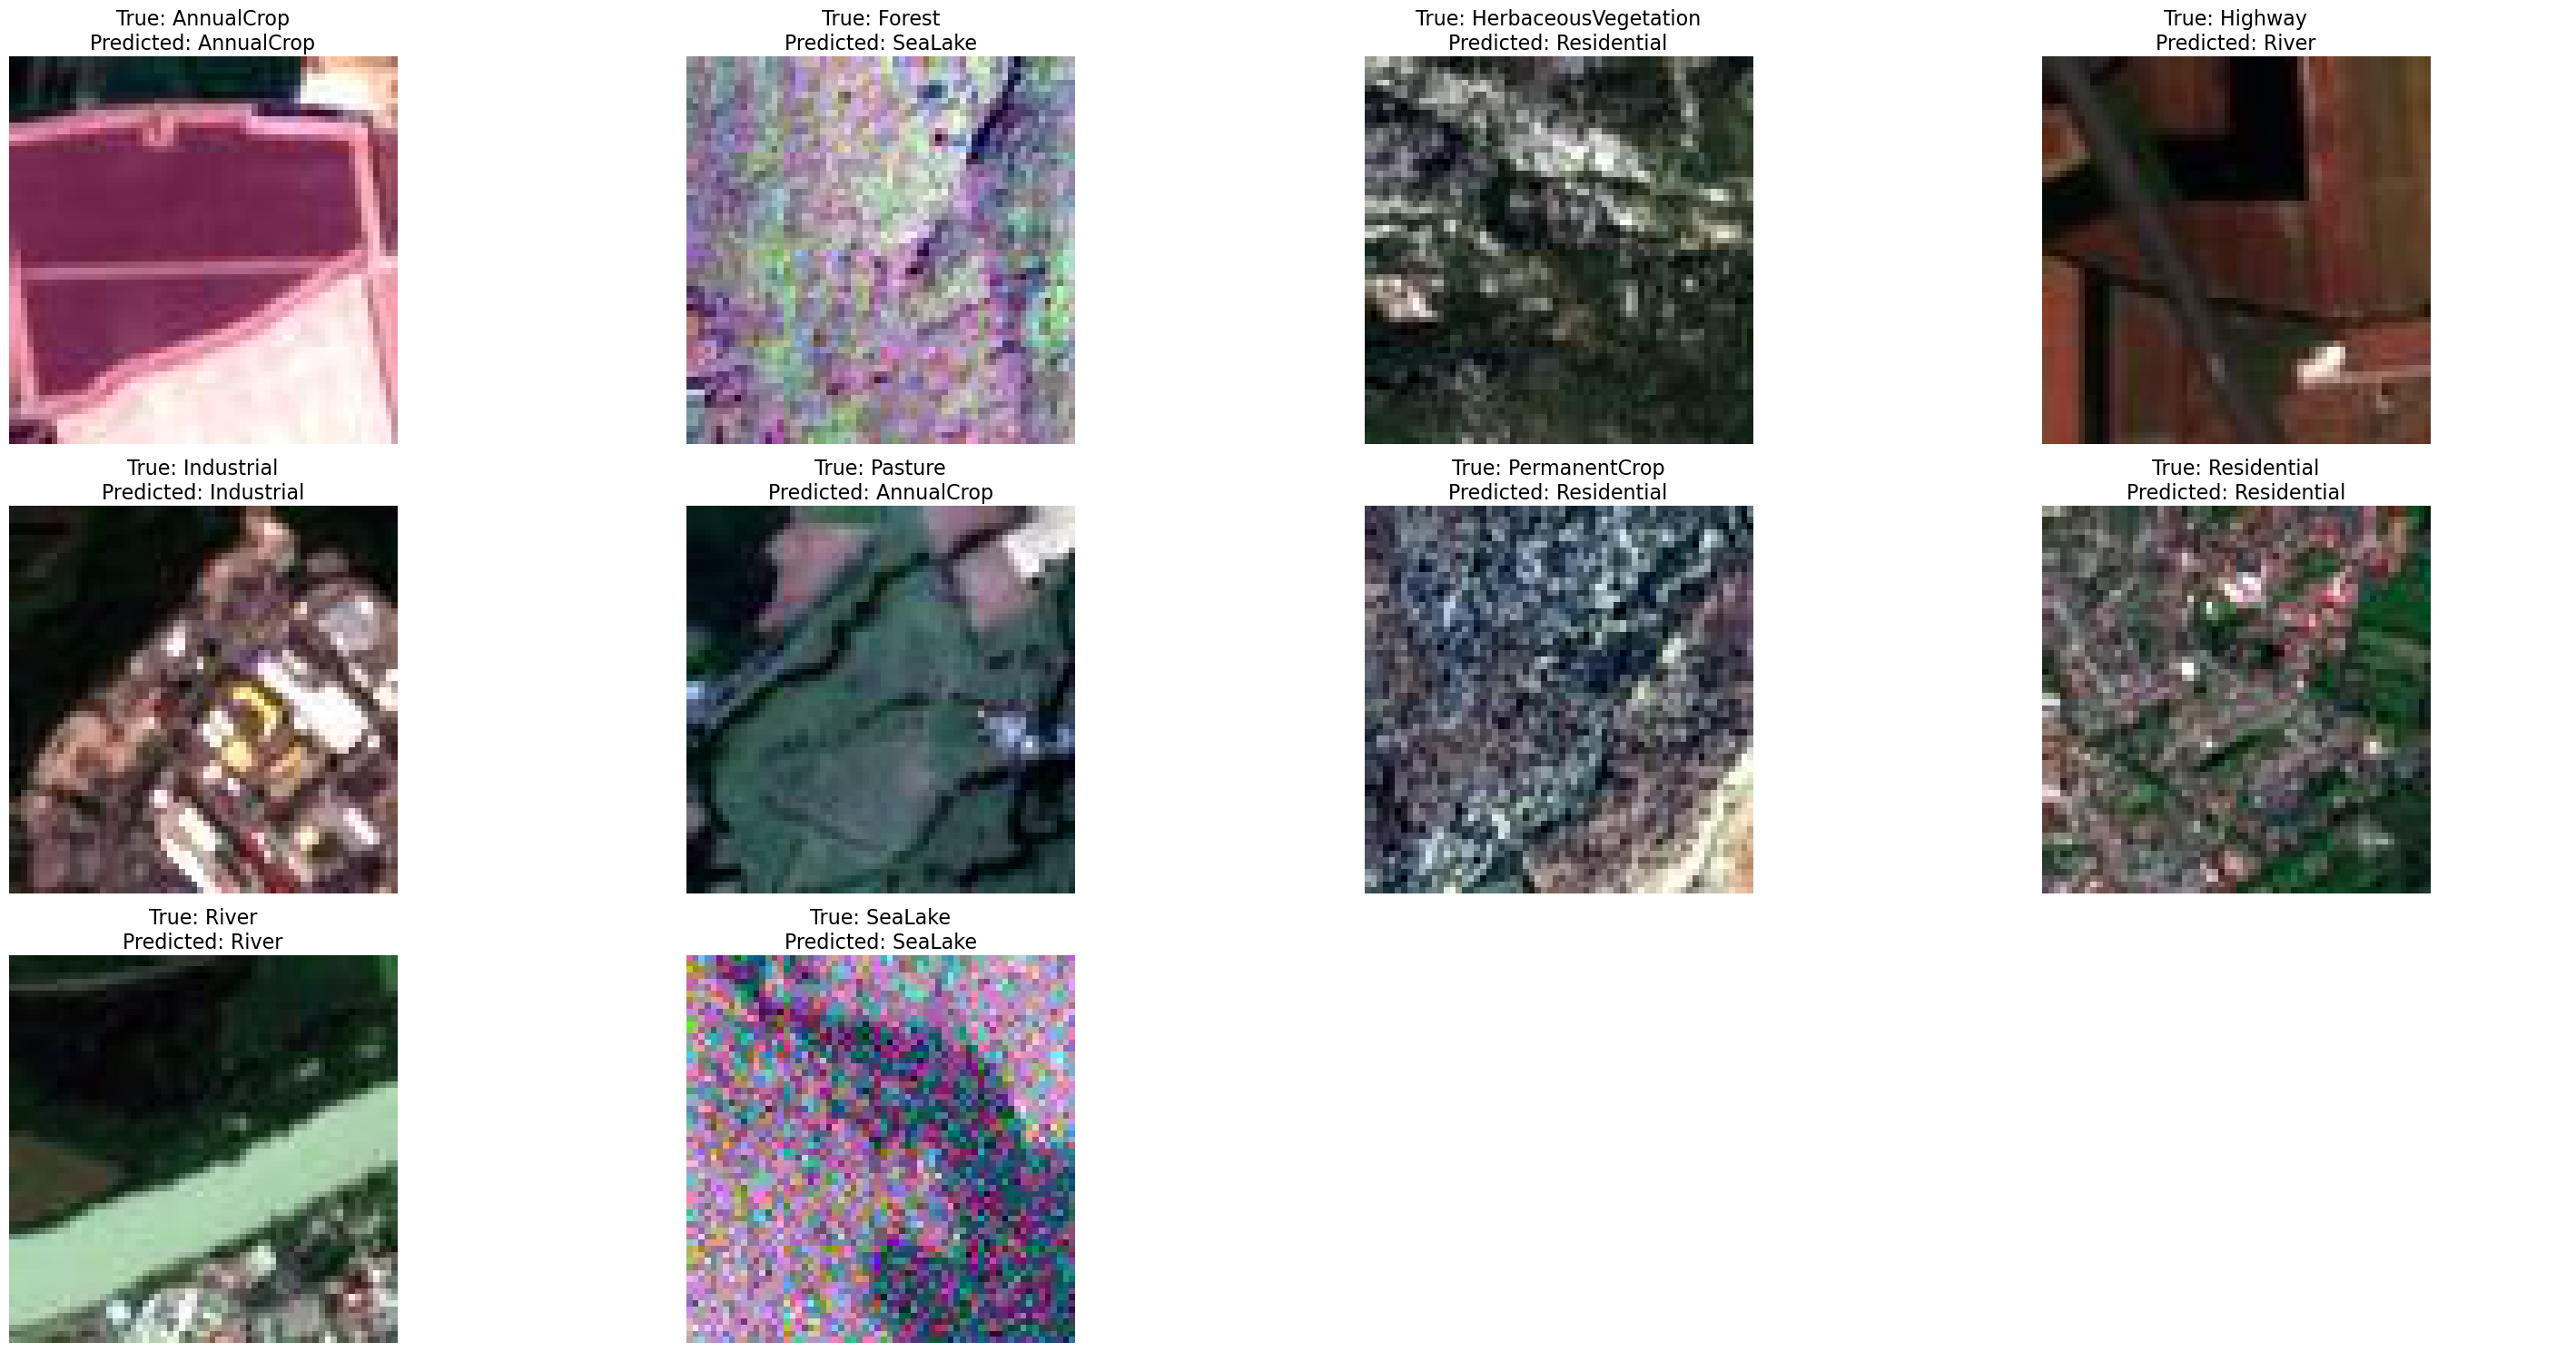

In [94]:
# Function to plot images with labels
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    ims = np.array(ims)
    ims = ims.astype(np.uint8)  # Ensure uint8 for proper display
    if ims.shape[-1] != 3:
        ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear', cmap=None)
        else:
            ax.axis('Off')
    plt.tight_layout()
    plt.show()

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))  # target size 64x64 for the model
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor, img

# Randomly select one image from each category and predict its class
selected_images = []
titles = []
for category in categories:
    category_path = os.path.join(test_path, category)
    image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_name)
    
    print(f"Selected image path: {image_path}")  # Print the path of the selected image
    
    img_tensor, img = load_and_preprocess_image(image_path)
    selected_images.append(image.img_to_array(img))  # Append image in [0, 255] range
    
    # Predict the class
    predictions = model.predict(img_tensor)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    actual_class_index = categories.index(category)
    titles.append(f"True: {category}\nPredicted: {categories[predicted_class_index]}")

# Display all selected images with predictions
plots(selected_images, rows=len(categories)//4 + 1, titles=titles)